<h1>1. Introduction</h1>

In this project I explore the dataset from the [Expedia Hotel Recommendations challenge](https://www.kaggle.com/c/expedia-hotel-recommendations). Expedia is a global travel technology company with various websites, including expedia.com, expedia.co.uk, etc. 

<b>The data</b> consists of event logs from various Expedia country sites. These events are generated whenever users search for a hotel stay on one of the websites (is_booking == 0), or create a booking (is_booking == 1). Various related event information is available, including the number of rooms, number of adults, the destination location id, geographic information on the location the user is searching from, and more. More info on the data can be found [here](https://www.kaggle.com/c/expedia-hotel-recommendations/data). 

<b>The goal of the original challenge</b> was to predict the 5 most likely hotel clusters a user will eventually book, based on the log information provided. Hotel clusters are groups of hotel that expedia generates internally, based on similarity (for example of location, star ratings, etc.). <b>My goal in this project</b> is to explore the dataset and try to predict the most likely hotel clusters too, as required in the original challenge. 

<b>Hardware:</b> Because on the large filesize, I am running this analysis on an EC2 t2.2xlarge instance on AWS, using an out-of-the-box Deep Learning AMI (Amazon Linux). However, when using a shell-generated sample as described below, or when only reading in a few columns at a time, a less powerful setup should be sufficient.

<p>Let's start!</p>

<h1>2. Import Libraries & Data Load </h1>

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
from pandas import Series
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
sample = pd.read_csv("/home/ec2-user/data/train_sample.csv")
test = pd.read_csv("/home/ec2-user/data/test.csv")
destinations = pd.read_csv("/home/ec2-user/data/destinations.csv")

#train = pd.read_csv("/home/ec2-user/data/train.csv", nrows=100000)
#sample = pd.read_csv("/home/ec2-user/data/train.csv")

<h2>2.1 Notes regarding data size and sampling</h2>

The main data file, train.csv is about 6.7GB, with <b>37,670,293 user events</b>. My t2.2xlarge EC2 instance can handle loading the file, but even with its 64GB Ram, simple operations with the dataframe quickly cause memory errors. 

One way to create a sample is to just read in the first n rows from train.csv, but since I am not sure if the data is truly random, I created a random sample file via shell. Later, if needed, I can load relevant columns only for all 37.7m rows.

<b>Code to create the sample in shell, with 500,000 user events:</b> <br>

```shell
head -1 train.csv > train_sample.csv <br>
tail -n +2 train.csv | shuf | head -500000 >> train_sample.csv```

In [1]:
## If full train.csv is loaded, use this cod to create random sample from dataframe. 
# sample = train.sample(frac=0.01, replace=True)

<h1> 3. First look at data</h1>

In [3]:
print(sample.info())
print(sample.head())
print(destinations.info())
print(destinations.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 24 columns):
date_time                    500000 non-null object
site_name                    500000 non-null int64
posa_continent               500000 non-null int64
user_location_country        500000 non-null int64
user_location_region         500000 non-null int64
user_location_city           500000 non-null int64
orig_destination_distance    320476 non-null float64
user_id                      500000 non-null int64
is_mobile                    500000 non-null int64
is_package                   500000 non-null int64
channel                      500000 non-null int64
srch_ci                      499382 non-null object
srch_co                      499382 non-null object
srch_adults_cnt              500000 non-null int64
srch_children_cnt            500000 non-null int64
srch_rm_cnt                  500000 non-null int64
srch_destination_id          500000 non-null int64
srch_destination_

<h2> 3.1 Analyse Missings</h2>

In [10]:
print(sample.isnull().sum())

date_time                         0
site_name                         0
posa_continent                    0
user_location_country             0
user_location_region              0
user_location_city                0
orig_destination_distance    179524
user_id                           0
is_mobile                         0
is_package                        0
channel                           0
srch_ci                         618
srch_co                         618
srch_adults_cnt                   0
srch_children_cnt                 0
srch_rm_cnt                       0
srch_destination_id               0
srch_destination_type_id          0
is_booking                        0
cnt                               0
hotel_continent                   0
hotel_country                     0
hotel_market                      0
hotel_cluster                     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 24 columns):
date_time   

### We learn:

In 0.2% of cases, srch_ci and srch_co (checkin- and checkout date) are missing. For these cases we remove the rows. For 36% of cases, orig_destination_distance (the distance between the location where the user searches, and the location he is interested in booking) is missing. Since this affects a large part of the data, we move on for now and decide later how to deal with it, incase we need the variable for modelling. 

sample size: 500,000<br>
missings in orig_destination_distance: 320,476 (36%)<br>
missings in srch_ci: 499,382 (0.2%)<br>
missings in srch_co: 499,382 (0.2%)

In [3]:
## remove rows where srch_ci/ srch_co are missing
sample = sample[pd.notnull(sample['srch_ci'])]

## 3.2 Type Conversions

In [4]:
## convert dates from object to datetime
sample.date_time = pd.to_datetime(sample.date_time)
sample.srch_ci = pd.to_datetime(sample.srch_ci)
sample.srch_co = pd.to_datetime(sample.srch_co)

## 3.3 Feature Engineering

In [5]:
## extract date components
sample['weekday'] = sample.date_time.dt.weekday
sample['year'] = sample.date_time.dt.year
sample['month'] = sample.date_time.dt.month
sample['day'] = sample.date_time.dt.day
sample['hour'] = sample.date_time.dt.hour
sample['stay_duration'] = sample.srch_co - sample.srch_ci
sample['stay_duration_float'] = sample.stay_duration/ np.timedelta64(1, 'D')

<h1> 4. Univariate Descriptives </h1>

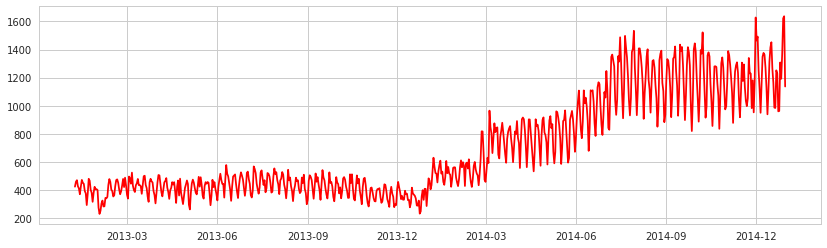

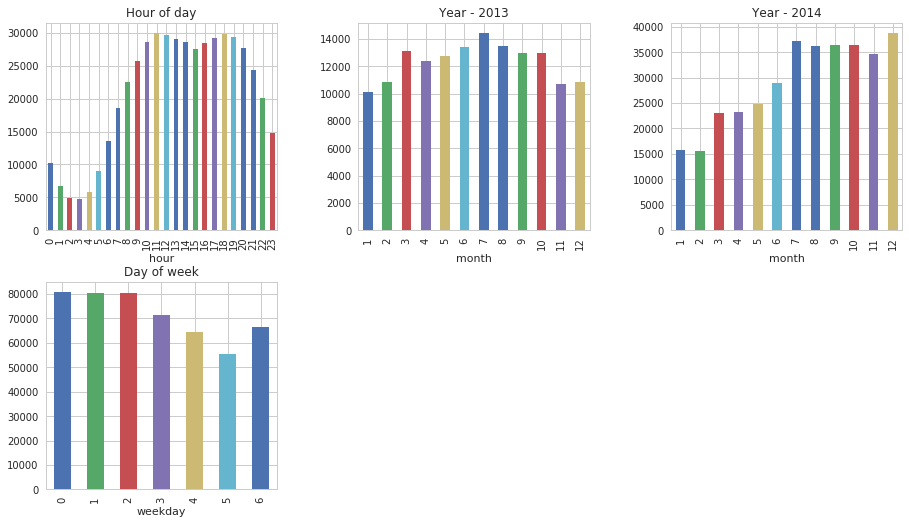

In [17]:
## distribution of events by dates
df = sample.groupby([sample['date_time'].dt.date]).size().reset_index(name='counts')
myCounts = df.counts.as_matrix()
myDates = pd.to_datetime(df.date_time)
plt.figure(figsize=[14,4])
plt.grid(True)
ts = pd.Series(myCounts, index=myDates, name='population')
plt.plot_date(x=myDates, y=myCounts, fmt="r-")
plt.show()

## hour-of-day, years, day-of-week
hours = sample.groupby(sample.hour).size()
months13 = sample[(sample.year == 2013)].groupby(sample.month).size()
months14 = sample[(sample.year == 2014)].groupby(sample.month).size()
days_of_week = sample.groupby(sample.weekday).size()
sns.set(style="whitegrid")
plt.figure(figsize=[14,12])
plt.subplot(331)
plt.title("Hour of day")
hours.plot.bar()
plt.subplot(332)
plt.title("Year - 2013")
months13.plot.bar()
plt.subplot(333)
plt.title("Year - 2014")
months14.plot.bar()
plt.subplot(334)
plt.title("Day of week")
days_of_week.plot.bar()
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

### We learn:
- There is approximately the same amount of data throughout 2013
- From Jan 2014, the amount of data strongly increases throughout the year
- There is a typical average activity on the website(s) throughout the day
- Monday - Wednesday (0-2) are the strongest, Saturday is weakest day

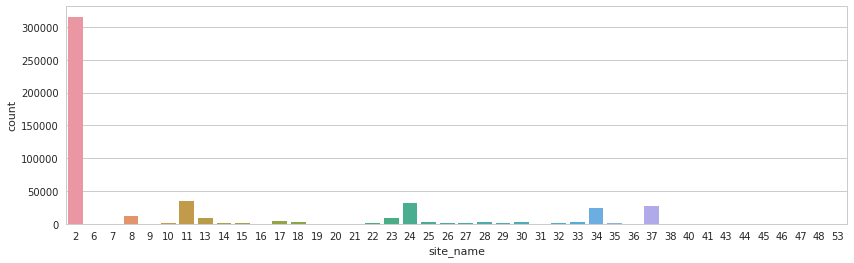

In [18]:
## site_name
plt.figure(figsize=[14,4])
sns.countplot(sample.site_name)

### We learn:
- By far the most common site_name is 2 (probably expedia.com)

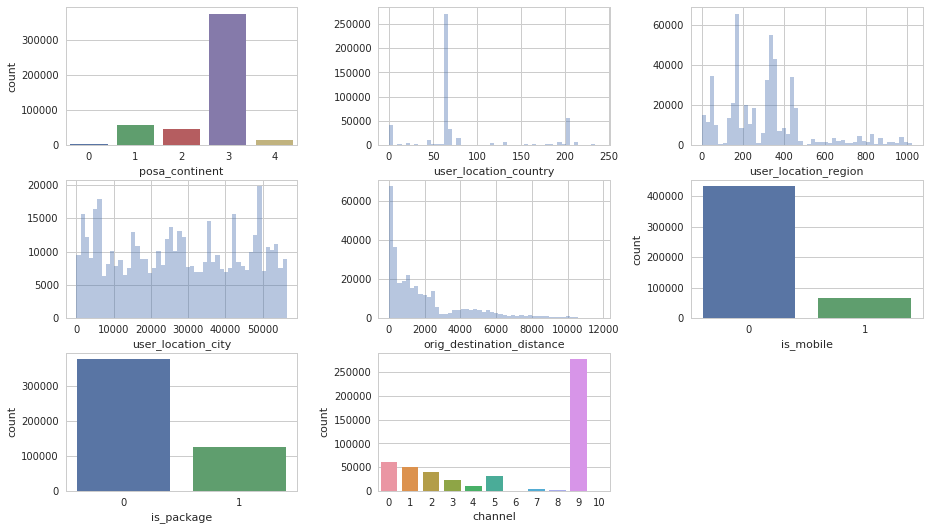

In [19]:
# further variables
plt.figure(figsize=[14,8])
plt.subplot(331)
sns.countplot(sample.posa_continent)
plt.subplot(332)
sns.distplot(sample.user_location_country, kde=False)
plt.subplot(333)
sns.distplot(sample.user_location_region, kde=False)
plt.subplot(334)
sns.distplot(sample.user_location_city, kde=False)
plt.subplot(335)
sns.distplot(sample[(sample.orig_destination_distance > 0)].orig_destination_distance, kde=False)
plt.subplot(336)
sns.countplot(sample.is_mobile)
plt.subplot(337)
sns.countplot(sample.is_package)
plt.subplot(338)
sns.countplot(sample.channel)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)

### We learn:
- Continent 3 is the most common
- One country is vastly more prevalent (no info on country codes used found)
- The majority of events has a low orig_destination_distance, the distribution is right-skewed and not normally distributed
- user_location_city and user_location_region do not give much information at first glance, although there are a few regions that are more prevalent than others
- Non-mobile transactions are vastly more common
- Most transactions are not packages
- Channel 9 is by far the most common (no info found so far what that refers to)

In [32]:
## Get top 10 rows by country
sample.user_location_country.groupby(sample.user_location_country).count().sort_values(ascending=False)[0:10]

user_location_country
66     269793
205     55614
3       29398
69      25451
77      12527
1       10179
46       9661
215      6485
133      5235
23       4182
Name: user_location_country, dtype: int64

The country with vastly more events than others is country 66. Unfortunately we do not have the corresponding country codes.

count    499089.000000
mean          3.347293
std           2.728512
min           0.000000
25%           1.000000
50%           3.000000
75%           4.000000
max          29.000000
Name: stay_duration, dtype: float64

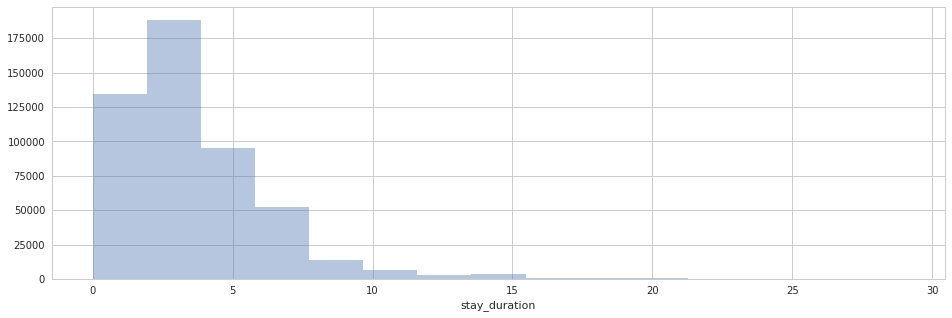

In [34]:
## checkin and Checkout
plt.figure(figsize=[16,5])
df = sample.stay_duration/ np.timedelta64(1, 'D')
df = df[(df < 30) & (df > -10)]
sns.distplot(df, kde=False, bins=15)
df.describe()

### We learn:
- On average, users are interested in a stay duration of 3.3 days with a standard deviation of 2.7 days.

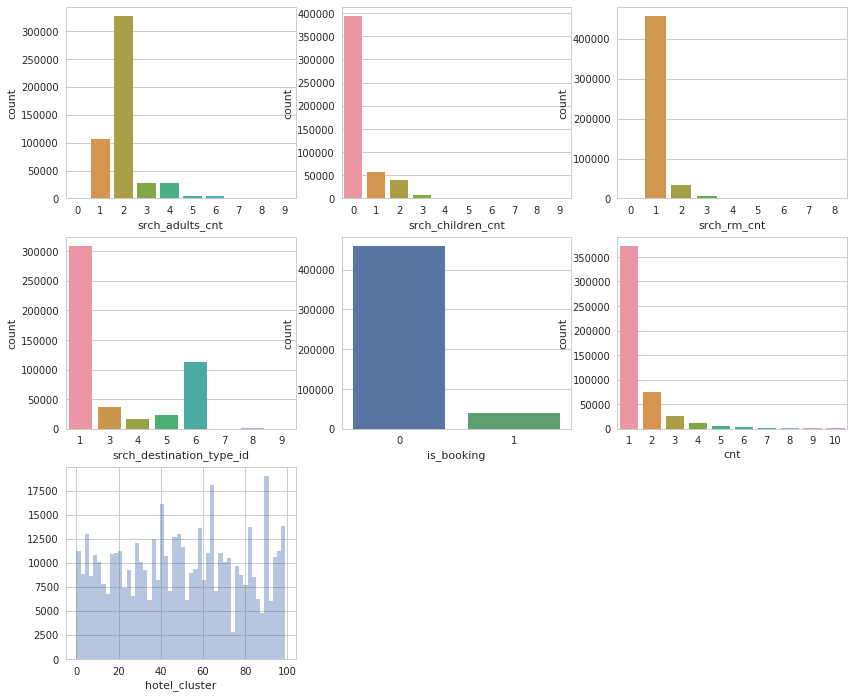

In [37]:
## further variables
plt.figure(figsize=[14,12])
plt.subplot(331)
sns.countplot(sample.srch_adults_cnt)
plt.subplot(332)
sns.countplot(sample.srch_children_cnt)
plt.subplot(333)
sns.countplot(sample.srch_rm_cnt)
plt.subplot(334)
sns.countplot(sample.srch_destination_type_id)
plt.subplot(335)
sns.countplot(sample.is_booking)
plt.subplot(336)
sns.countplot(sample[(sample.cnt <= 10)].cnt)
plt.subplot(337)
sns.distplot(sample.hotel_cluster, kde=False)

### We learn:
- By far the most common search is for 1 room, 2 adults and no children
- srch_destination_type_id == 1 is the most common (unfortunately also no info here what it means)
- Only about 7% of events are bookings
- Count of user transactions cannot be interpreted as data so far is based on 1% sample
- Most user events only have 1 similar event from that user in the same timeframe (cnt)

# 5. Multivariate Descriptives

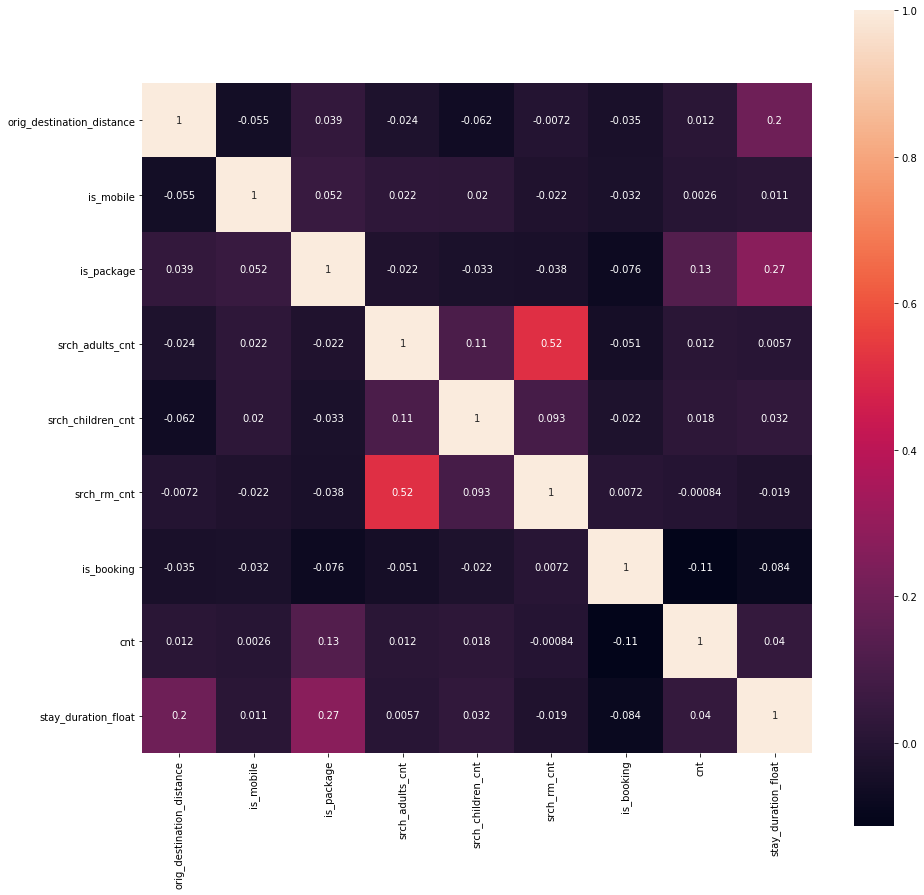

In [8]:
## heatmap
numeric_vars = sample[['orig_destination_distance','is_mobile','is_package','srch_adults_cnt','srch_children_cnt',
                       'srch_rm_cnt','is_booking','cnt', 'stay_duration_float']]
plt.figure(figsize=(15,15))
foo = sns.heatmap(numeric_vars.corr(), square=True, annot=True)

### We learn:
- srch_room_cnt is highly correlated with srch_adults_cnt
- stay_duration is correlated with orig_destination_distance, so longer distances mean longer duration
- stay_duration is also correlated with is_package, so duration seems longer when booked as package
- the number of similar interactions (cnt) is correlated with is_package
- the number of similar interactions (cnt) is negatively correlated with is_booking

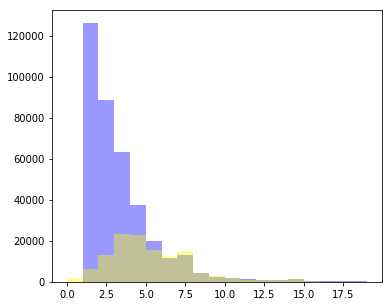

In [75]:
# is_package X stay_duration_float
plt.figure(figsize=[13,5])
plt.subplot(121)
sns.distplot(sample[(sample.is_package == 0)]['stay_duration_float'].values, bins=range(0, 20, 1), kde=False, color="blue")
sns.distplot(sample[(sample.is_package == 1)]['stay_duration_float'].values, bins=range(0, 20, 1), kde=False, color="yellow")

### We learn:
- stay_duration is right skewed when is_package == 0 (blue)
- stay_duration is approximately normally distributed when is_package == 1 (yellow)
- the large amount of cases with stay_duration <= 5 days for is_package == 0 causes the positive association between the variables.

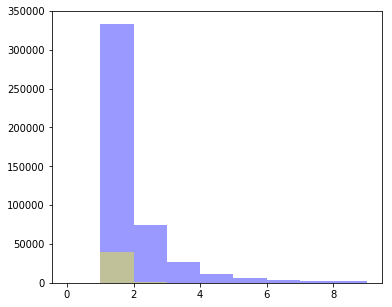

In [76]:
# cnt X is_booking
plt.figure(figsize=[13,5])
plt.subplot(121)
sns.distplot(sample[(sample.is_booking == 0)]['cnt'].values, bins=range(0, 10, 1), kde=False, color="blue")
sns.distplot(sample[(sample.is_booking == 1)]['cnt'].values, bins=range(0, 10, 1), kde=False, color="yellow")

### We learn:
- when is_booking == 1, then cnt == 1

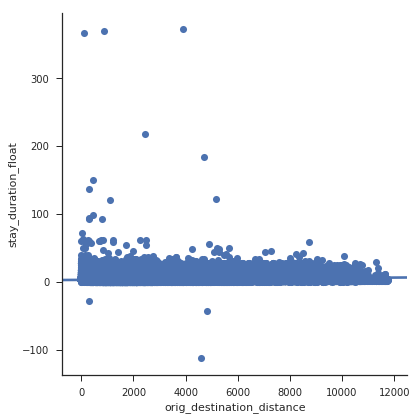

In [39]:
# orig_destination_distance x stay_duration
sns.set(style="ticks")
sns.lmplot(x="orig_destination_distance", y="stay_duration_float", data=sample,
        ci=None, palette="muted", size=6,
           scatter_kws={"s": 50, "alpha": 1})

### We learn:
- the association between orig_destination_distance and stay_duration_float seems spurious

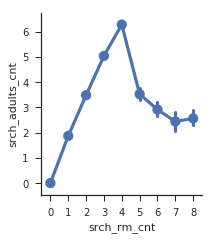

In [40]:
## srch_rm_cnt x srch_adults_cnt
g = sns.factorplot(x="srch_rm_cnt", y="srch_adults_cnt",
                   data=sample, aspect=0.9, size=3.5, ci=95.0)

### We learn:
- when more than 4 rooms are requested, number of adults searched for suddenly drops to 2.5 - 3 adults, even for as many as 8 rooms. Need to investigate this.

In [28]:
## is_booking x is_mobile
tab = pd.crosstab(sample['is_booking'], sample['is_mobile'], margins=True, normalize=False)
print(tab)

is_mobile        0      1     All
is_booking                       
0           396275  63322  459597
1            35904   3881   39785
All         432179  67203  499382


### We learn:
- 92% of transactions have no booking
- 87% of transactions are non-mobile
- bookings are less likely on mobile (8% of non-mobile transactions made a booking vs 6% of mobile transactions)

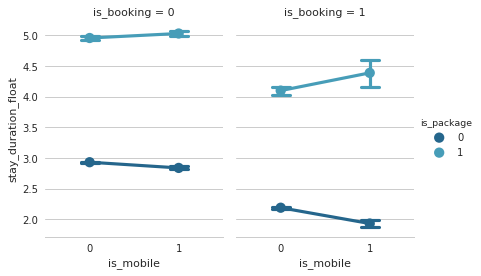

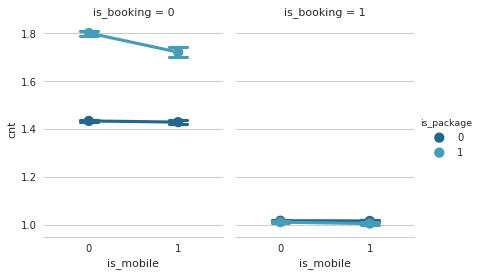

In [19]:
## stay_duration x is_booking x is_mobile x is_package
## cnt x is_booking x is_mobile x is_package
sns.set(style="whitegrid")
g = sns.factorplot(x="is_mobile", y="stay_duration_float", hue="is_package", col="is_booking",  
                   data=sample, capsize=.2, palette="YlGnBu_d", size=4, aspect=0.75)
h = sns.factorplot(x="is_mobile", y="cnt", hue="is_package", col="is_booking",  
                   data=sample, capsize=.2, palette="YlGnBu_d", size=4, aspect=0.75)
g.despine(left=True)
h.despine(left=True)

### We learn:
- top chart: stay_duration is much higher for travel packages
- bottom chart: for clicks (booking == 0), there are more related user events when click is part of a package deal; when is_booking == 1, cnt is always = 1

<h1> 6. Modelling</h1>

Our goal is to predict the five hotel clusters a user is most likely to book. For that, for each srch_destination_id I will rank all hotel_clusters based on number of user events they receive. Afterwards I will try to increase the MAP by taking into account other variables.

As in the original challenge, I will evaluate the predictive power of the model using [Mean Average Precision](http://fastml.com/what-you-wanted-to-know-about-mean-average-precision/) with a cutoff at 5. This means that up to 5 hotel clusters can be submitted for each user event, ordered by most relevant (first) to least relevant (last). Since Sklearn does not come with a builtin function for MAP, I utilize an existing python implementation found on the internet (see below).

To prevent overfit, I use a train_test_split of the sampled data.

In [11]:
## Define functions to calculate mean average precision, taken from:
## https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
def apk(actual, predicted, k=10):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    #if not actual:
    #    return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

## 6.1 Model without weight

Here I rank hotel clusters, given all rows equal weight.

In [34]:
# apply a train/ test split
train, test = train_test_split(sample[['is_booking', 'srch_destination_id', 'hotel_cluster']], test_size=0.2)

In [35]:
#### Get most common hotel clusters per srch_destination_id

## load selected columns from complete file
#train = pd.read_csv("/home/ec2-user/data/train.csv", usecols=['is_booking', 'srch_destination_id', 'hotel_cluster'])

cluster_ranking = train.groupby([train.srch_destination_id, train.hotel_cluster]).size().reset_index(name='counts')
cluster_ranking = cluster_ranking.sort_values(['srch_destination_id', 'counts'], ascending=[True,False])
cluster_ranking['RN'] = cluster_ranking.groupby(['srch_destination_id']).cumcount() + 1

## Turn cluster_ranking into list, which can be used by MAP function
cluster_list = cluster_ranking[(cluster_ranking.RN <= 5)].groupby('srch_destination_id')['hotel_cluster'].apply(list)
cluster_list.head()

srch_destination_id
1                    [20]
2                    [20]
4    [30, 62, 82, 22, 25]
7                    [42]
8    [43, 48, 32, 51, 94]
Name: hotel_cluster, dtype: object

In [36]:
# merge the test dataset with the 5 best hotel cluster matches which we got from the train dataset
test = test[(test.is_booking == 1)].merge(cluster_list.to_frame().reset_index(), left_on='srch_destination_id', 
                          right_on='srch_destination_id', how='inner')
test.rename(columns={'hotel_cluster_x': 'hotel_cluster', 'hotel_cluster_y': 'hotel_cluster_matches'}, inplace=True)

In [37]:
y_true = test.hotel_cluster.to_frame().values.tolist()
y_scores = test.hotel_cluster_matches
mapk(y_true, y_scores, k=5)

0.2946827992151733

### We learn:
- After first run we get a mean average precision of 0.28 - 0.29
- To improve this we will next try to give more weight to booking events compared to click events

## 6.2 Model with weight

Here I do the same as above, but count clicks as only half as important as bookings. The idea behind that is that an actual booking, where a user commits to a hotel choice, should have more importance in our ranking than a click event, where the user might still be comparing different options.

In [30]:
## Create a weight for each row which we can use for ranking
def apply_weight(row):
    weight = 1
    if row['is_booking'] == 0:
        weight = 0.5  
    return weight

sample['weight'] = sample.apply(lambda row : apply_weight (row), axis=1) 

In [31]:
# apply a train/ test split
train, test = train_test_split(sample[['is_booking', 'srch_destination_id', 'hotel_cluster', 'weight']], test_size=0.2)

In [32]:
## Rank hotel clusters, taking weight into account
cluster_ranking = train[['srch_destination_id', 'hotel_cluster', 'weight']].groupby(['srch_destination_id', 'hotel_cluster']).sum().reset_index()
cluster_ranking_sort = cluster_ranking.sort_values(['srch_destination_id', 'weight'], ascending=[True,False])
cluster_ranking_sort['RN'] = cluster_ranking_sort.groupby(['srch_destination_id']).cumcount() + 1

## Turn cluster_ranking into list, which can be used by MAP function
cluster_list = cluster_ranking_sort[(cluster_ranking_sort.RN <= 5)].groupby('srch_destination_id')['hotel_cluster'].apply(list)

In [33]:
# merge the test dataset with the 5 best hotel cluster matches which we got from the train dataset
test = test[(test.is_booking == 1)].merge(cluster_list.to_frame().reset_index(), left_on='srch_destination_id', 
                          right_on='srch_destination_id', how='inner')
test.rename(columns={'hotel_cluster_x': 'hotel_cluster', 'hotel_cluster_y': 'hotel_cluster_matches'}, inplace=True)

In [34]:
y_true = test.hotel_cluster.to_frame().values.tolist()
y_scores = test.hotel_cluster_matches
mapk(y_true, y_scores, k=5)

0.289477906422098

### We learn:
- We now gave clicks have half the weight of bookings
- the MAP score stays at about 29%
- so, sofar, there was no effect from the different weights

<h1>7. Summary and further steps</h1>

- So far, I have achieved a 29% mean average precision for predicting hotel clusters, using cross validation. 29% should be enough to get a first recommendation going. 
- The score could so far not be elevated by applying is_booking and is_package as weights.
- So far, the only predictor variable has been the location the user was searching for (srch_location_id). Next I would like to include more predictors, including orig_destination_distance, channel, is_package, srch_children_cnt, srch_adults_cnt and data from the destinations file.
- One challenge using a more complex model with more predictors has been, as mentioned above, that the main predictor srch_destination_id takes about 65,000 different values and is categorical and is thus difficult to include in a logistic regression, k-means clustering, etc. 
- One solution could be dimensionality reduction and another to keep srch_location_id out of the first model and afterwards combine the output with another model including the variable. I will explore these options next.